## Cleaning FERC 1 Fuel data
This notebook is meant to help get you understand the data cleaning process for FERC Form 1 fuel data for heat content and price per MMBTU data.

In [3]:
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..','..')))
from pudl import pudl, ferc1, eia923, settings, constants
from pudl import models, models_ferc1, models_eia923
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
pudl_engine = pudl.connect_db()

In [5]:
fuel_df = pd.read_sql('''SELECT * from fuel_ferc1''',pudl_engine)
coal = fuel_df[fuel_df.fuel=='coal']
gas = fuel_df[fuel_df.fuel=='gas']
oil = fuel_df[fuel_df.fuel=='oil']

Then, we'll define a function that takes as arguments: 

- a data series to be cleaned
- minimum and maximum values bounding the reasonable range of values for the series
- multipliers (a list) to the minimum and maximum values are divided to define additional ranges of data, which are brought into the reasonable range by multiplying the values in the additional ranges by the multipliers (e.g. if a set of values is 1000 times too large to fit in the reasonable range, its multiplier will be .001).

The function will return a cleaned series.

In [4]:
def fixit(tofix, min, max, mults):
    
    fixed = tofix.copy()
    fixed = fixed[fixed > 0]
    for mult in mults:
        fixed = fixed.apply(lambda x: x*mult if x > min/mult and x < max/mult else x)
    fixed = fixed.apply(lambda x: np.nan if x < min or x > max else x)
    return(fixed)

In [5]:
def showfix(tofix,fixed,title,xlabel,ylabel):
    
    min_1 = tofix[tofix > 0].min()
    max_1 = tofix.max()
    fraction_lost =  ( fixed.isnull().sum() / len(fixed) ) * 100
    show_fraction = 'The percentage of values set to NaN is {} %'\
    .format(round(fraction_lost,2))
    font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 14,
        }
    
    fig_1 = plt.figure(figsize=(16,12))
    plt.subplot(2,1,1)
    plt.title(title)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    ax = fig_1.axes[0]
    ax.set_xscale('log')
    ax.set_yscale('log')

    plt.xlim(min_1,max_1)
    plt.hist(tofix, bins=np.logspace(np.log10(min_1), np.log10(max_1), 100))
    
    plt.subplot(2,1,2)
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.grid()
    plt.hist(fixed.dropna(),bins=100)
    plt.text(0, .05, show_fraction, transform=fig_1.transFigure,fontdict=font)
    plt.show()

We'll define a simple graphing function to help us make the graph and a flexible graphing function to help us make slightly more complex graphs later on.

In [6]:
def simplegraph(series,xlabel,ylabel,title,range1,range2):
    plt.figure(figsize=(10,7))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.hist(series,bins=100,range=(range1,range2))
    plt.show()

In [7]:
def flexiblegraph(series,xlabel,ylabel,title,yscale,range1,range2,bins):
    plt.figure(figsize=(10,7))
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.title(title)
    plt.yscale(yscale)
    plt.hist(series,bins=bins,range=(range1,range2))
    plt.show()

In [8]:
fuel_rc = pd.read_sql('''SELECT fuel_quantity,energy_source, fuel_group, average_heat_content, fuel_cost, plant_id, report_date \
FROM fuel_receipts_costs_eia923''', con = pudl_engine)

In [9]:
fuel_rc['fuel_cost'] = fuel_rc['fuel_cost'] * .01

In [10]:
fuel_rc

,fuel_quantity,energy_source,fuel_group,average_heat_content,fuel_cost,plant_id,report_date
0,24076.0,BIT,Coal,22.660,5.444,3,2011-01-01
1,151180.0,BIT,Coal,22.660,4.044,3,2011-01-01
2,3645148.0,NG,Natural Gas,1.020,4.797,3,2011-01-01
3,39546.0,NG,Natural Gas,1.019,4.739,3,2011-01-01
4,4281.0,BIT,Coal,20.740,3.783,7,2011-01-01
5,146973.0,NG,Natural Gas,1.011,4.880,7,2011-01-01
6,49397.0,BIT,Coal,24.720,4.544,8,2011-01-01
7,27473.0,BIT,Coal,24.016,2.990,8,2011-01-01
8,8959.0,BIT,Coal,22.074,3.567,8,2011-01-01
9,44066.0,BIT,Coal,24.850,4.604,8,2011-01-01


In [12]:
fuel_rc.fuel_group.value_counts()

Natural Gas       98508
Coal              87434
Petroleum         18573
Petroleum Coke     1068
Other Gas           764
Name: fuel_group, dtype: int64

In [13]:
eia_rc_coal = fuel_rc[fuel_rc.fuel_group == 'Coal']

In [14]:
eia_rc_gas = fuel_rc[fuel_rc.fuel_group == 'Natural Gas']

In [15]:
eia_rc_oil = fuel_rc[fuel_rc.fuel_group == 'Petroleum']

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


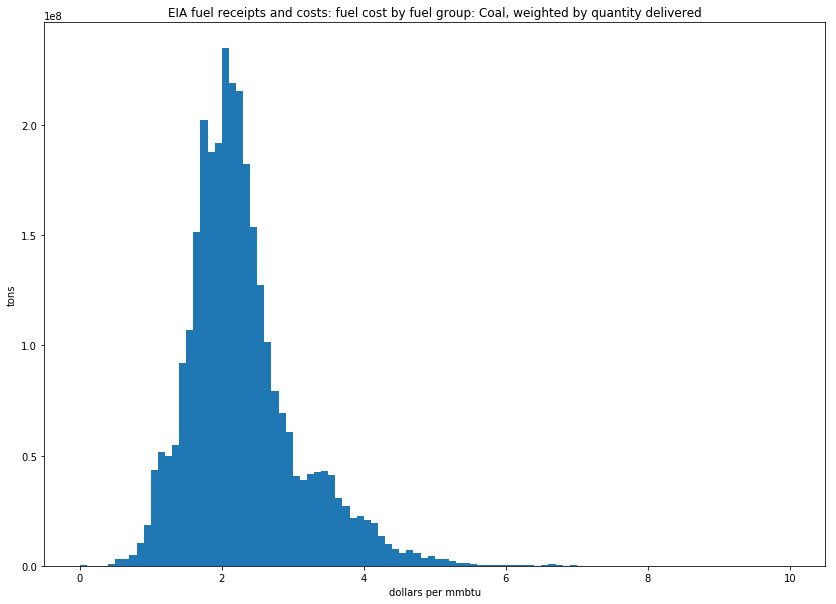

In [16]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_coal.fuel_cost,range=(0,10),weights=eia_rc_coal.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Coal, weighted by quantity delivered')
plt.ylabel('tons')
plt.xlabel('dollars per mmbtu')

The population begins around .5.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


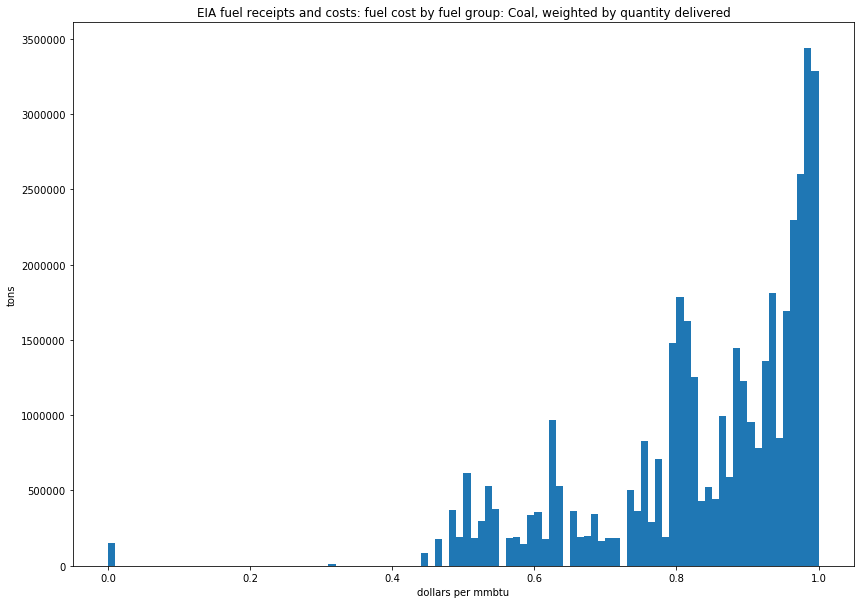

In [17]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_coal.fuel_cost,range=(0,1),weights=eia_rc_coal.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Coal, weighted by quantity delivered')
plt.ylabel('tons')
plt.xlabel('dollars per mmbtu')

The population ends around 7.5.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


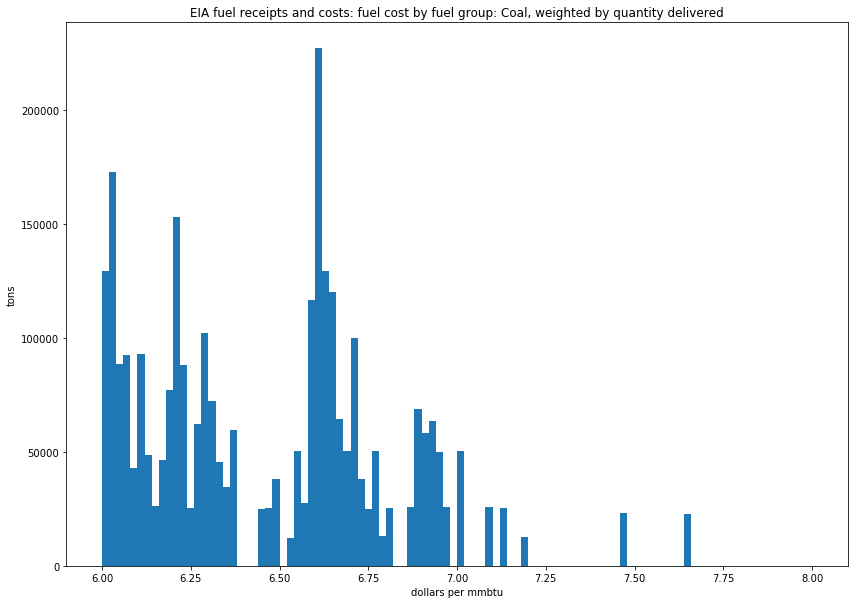

In [19]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_coal.fuel_cost,range=(6,8),weights=eia_rc_coal.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Coal, weighted by quantity delivered')
plt.ylabel('tons')
plt.xlabel('dollars per mmbtu')

Returning our attention to the FERC data, there are two outlying populations: 
- one population around .002, which values are all associated with one utility, respondent_id 130.
- one population around 200, which is off by a factor of 100, as the utility reported cost in cents per mmbtu, rather than dollars per mmbtu.

Let's take a look at the population around .001. All of these values appear to be attributable to `respondent_id` 130.

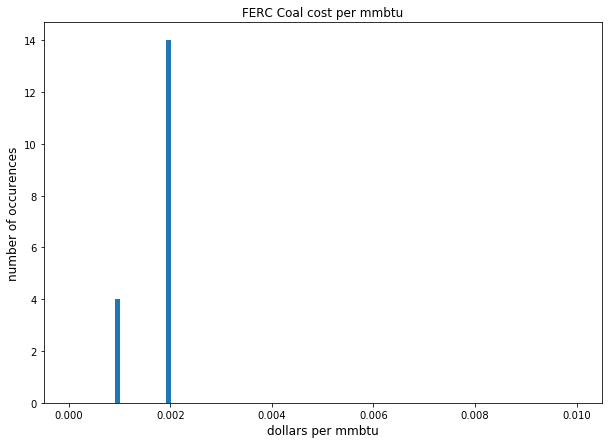

In [20]:
simplegraph(coal.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Coal cost per mmbtu', .00001,.01)

In [21]:
coal[(coal.fuel_cost_per_mmbtu > 0) & (coal.fuel_cost_per_mmbtu < .004)]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
1055,1056,130,Sooner,2007,coal,ton,3780090.0,0.017590,19.708,0.0,0.001,11.0,10.238
1058,1059,130,Muskogee,2007,coal,ton,4998369.0,0.017577,20.719,0.0,0.001,12.0,10.495
1602,1603,130,Sooner,2008,coal,ton,4510024.0,17.584000,19.349,0.0,0.001,11.0,10.299
1605,1606,130,Muskogee,2008,coal,ton,5836557.0,17.582000,20.920,0.0,0.001,18.0,10.459
2869,2870,130,Sooner,2009,coal,ton,3877888.0,17.605000,30.904,0.0,0.002,18.0,10.425
2872,2873,130,Muskogee,2009,coal,ton,5139685.0,17.630000,28.810,0.0,0.002,15.0,9.235
5032,5033,130,Sooner,2010,coal,ton,3471416.0,17.600000,33.949,0.0,0.002,20.0,10.197
5034,5035,130,Muskogee,2010,coal,ton,5046150.0,17.581000,31.196,0.0,0.002,190.0,10.939
6468,6469,130,Sooner,2011,coal,ton,4059847.0,17.601000,36.723,0.0,0.002,22.0,10.469
6470,6471,130,Muskogee,2011,coal,ton,5321781.0,17.640000,32.789,0.0,0.002,20.0,10.831


Let's take a look at the population around 200. The shape mirrors the primary distribution. These values were likely the result of a utility entering cost per mmbtu in cents rather than dollars.

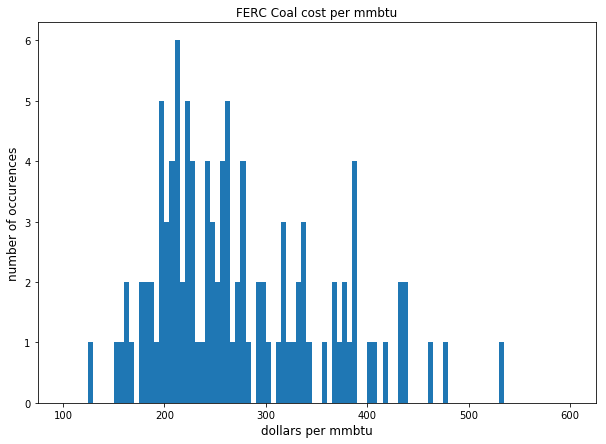

In [22]:
simplegraph(coal.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Coal cost per mmbtu', 100,600)

There is also a cluster of values around 2000 but it is unclear what is causing these values to be off by 1000. The shape does not resemble the primary distrubtion as much as the previous population.

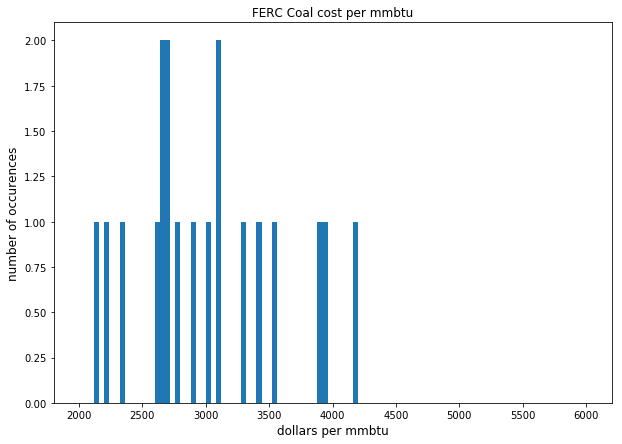

In [23]:
simplegraph(coal.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Coal cost per mmbtu', 2000,6000)

When we apply the two cleaning functions, we see a distribution with two peaks, which appear to correspond with the price premium subbituminous higher heat content coal versus lower heat content lignite coal.

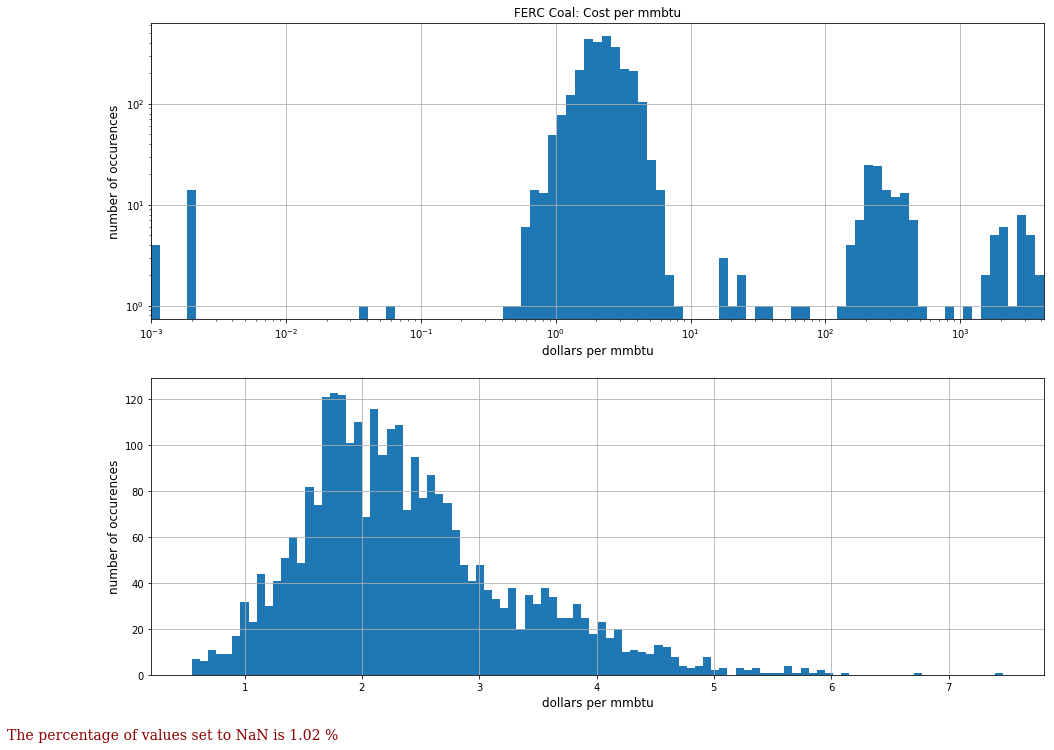

In [192]:
to_fix_cost_per_mmbtu_coal = coal.fuel_cost_per_mmbtu
fixed_cost_per_mmbtu_coal = fixit(coal.fuel_cost_per_mmbtu,.5,7.5,[.01,.001])

showfix(coal.fuel_cost_per_mmbtu,fixed_cost_per_mmbtu_coal,'FERC Coal: Cost per mmbtu',\
        'dollars per mmbtu','number of occurences')

### Gas cost per mmbtu
As we turn our attention to natural gas, one expects to find the main population between roughly 2.5 and 15 dollars per mmbtu (per EIA Henry Hub data https://www.eia.gov/dnav/ng/hist/rngwhhdd.htm). One does see residential prices as high as nearly 40 dollars per mcf (in Hawaii! https://www.eia.gov/dnav/ng/ng_pri_sum_a_epg0_prs_dmcf_m.htm). Looking at the data near 5, one finds the main population begins after 2.5 and with a tail extending out to 40 dollars per mmbtu.

For natural gas pricing, EIA 923 instructions instruct respondents to "include the following pipeline charges: fuel losses, transportation reservation charges, balancing costs, and distribution system costs outside of the plant. Because these types of fees can skew the cost of the fuel per MMBtu, provide an explanation." Therefore, we're likely to see some values above the 15 dollars per mmbtu Henry Hub maximum, although we shouldn't see consistently high pricing like we see in the residential data.

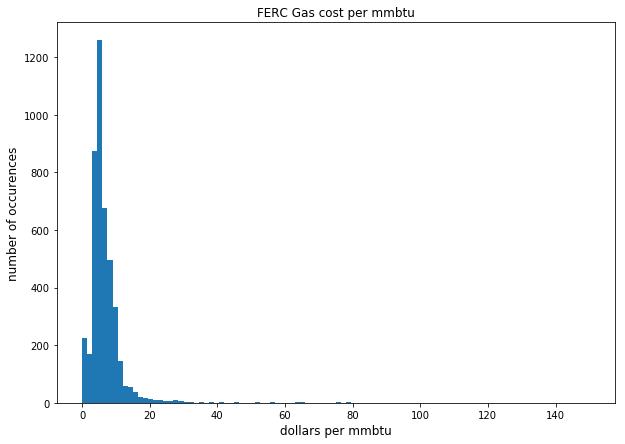

In [37]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', 0,150)

When we look at EIA fuel cost data weighted by quantity delivered we see a clear drop off after 15 dollars per mcf and a tail of values going out to roughly 35.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


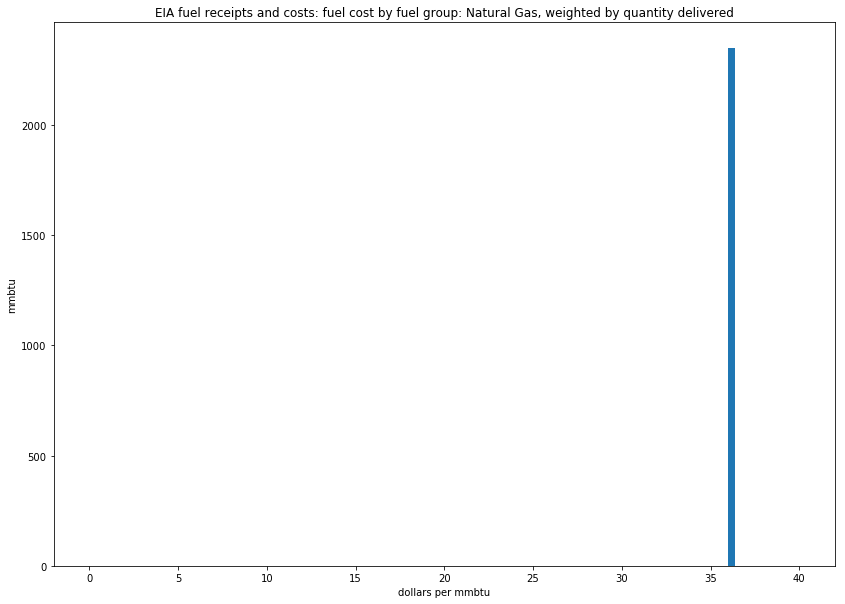

In [40]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_gas.fuel_cost,range=(0,40),weights=eia_rc_gas.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Natural Gas, weighted by quantity delivered')
plt.ylabel('mmbtu')
plt.xlabel('dollars per mmbtu')

This tail is more apparent when fuel costs are not weighted by quantity delivered.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


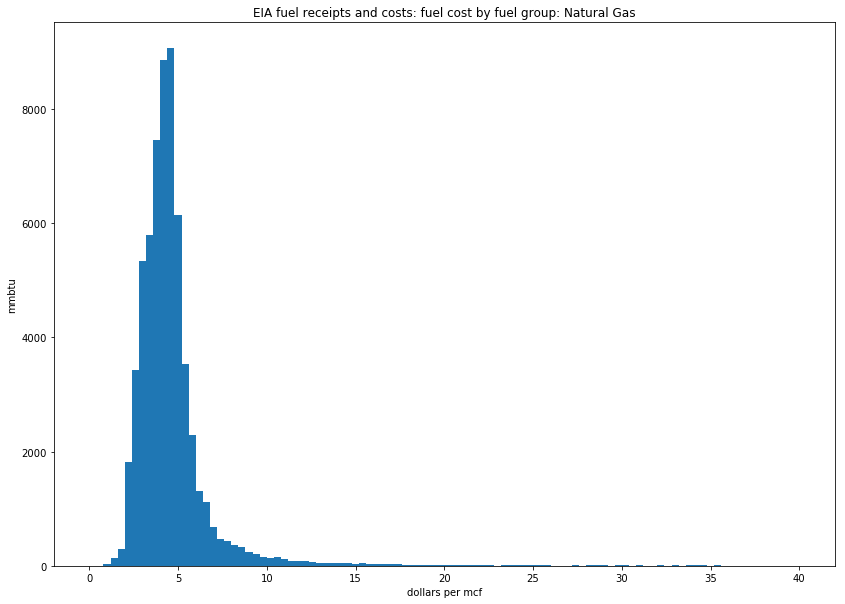

In [24]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_gas.fuel_cost,range=(0,40),bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Natural Gas')
plt.ylabel('mmbtu')
plt.xlabel('dollars per mcf')

The population appears to begin around 1 - it's difficult to say exactly where to draw the line.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


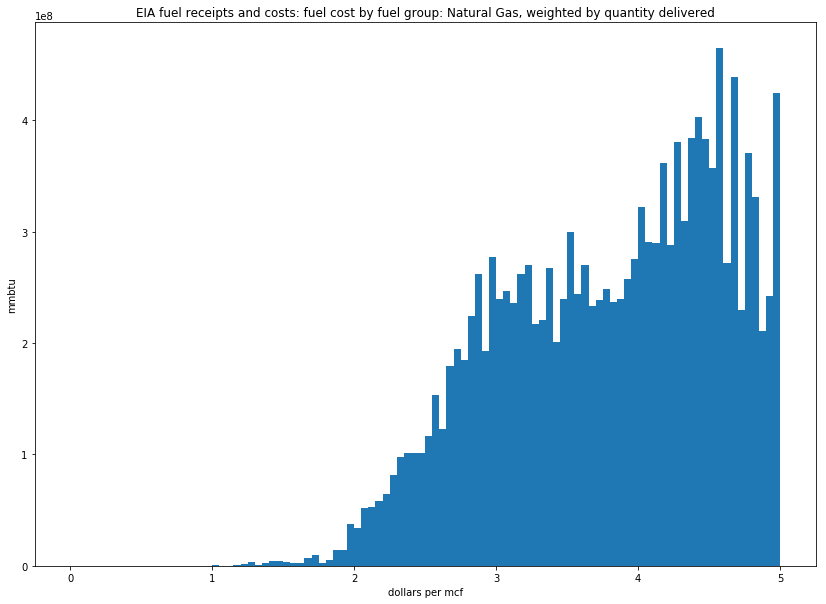

In [25]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_gas.fuel_cost,range=(0,5),weights=eia_rc_gas.fuel_quantity,bins=100)
plt.title('EIA fuel receipts and costs: fuel cost by fuel group: Natural Gas, weighted by quantity delivered')
plt.ylabel('mmbtu')
plt.xlabel('dollars per mcf')

Zooming in.

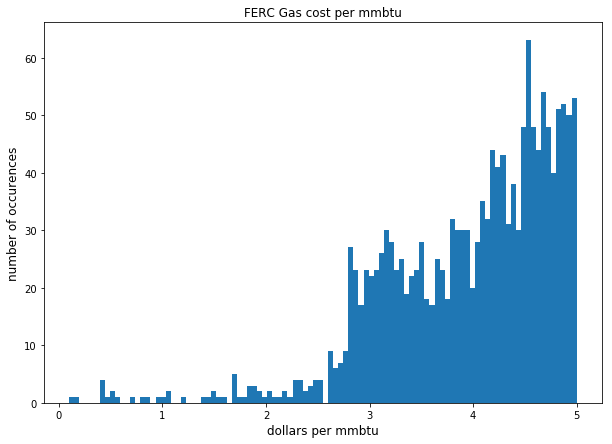

In [295]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', .1,5)

The distribution begins to drop off considerable after 12 dollars per mmbtu.

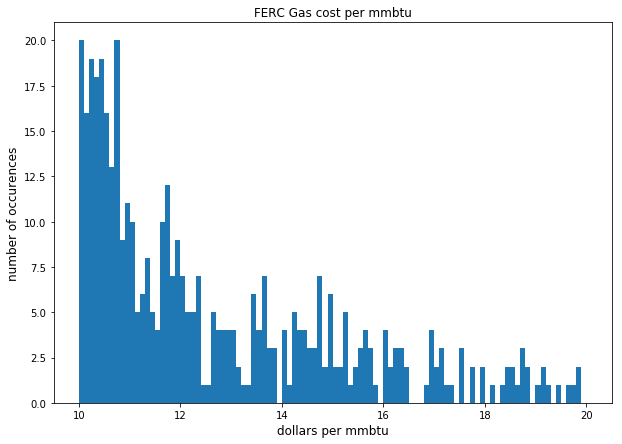

In [68]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', 10,20)

The tail continues and drops off even further after roughly 50 dollars per mmbtu.

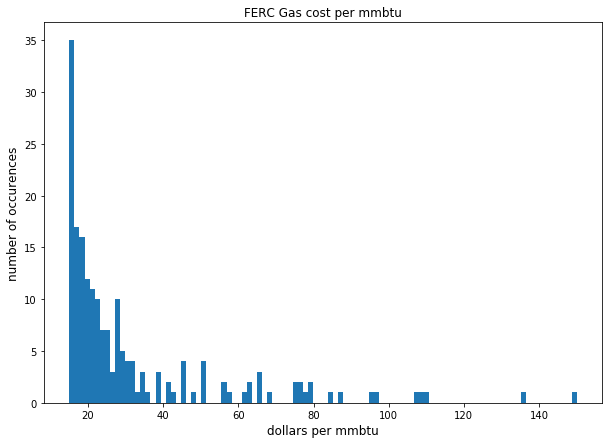

In [69]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', 15,150)

When weighted by quantity burned, we see a much tighter distribution and values don't range past 35 dollars per mmbtu.

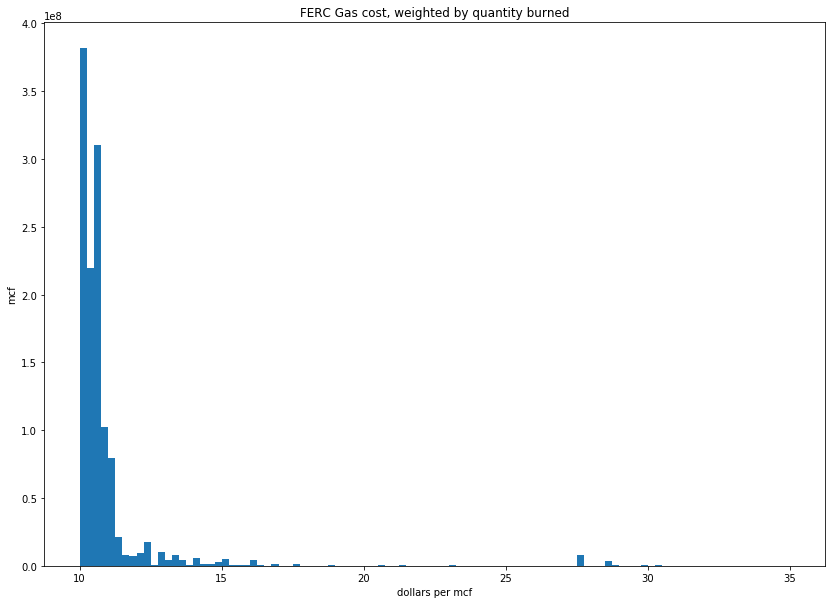

In [153]:
plt.figure(figsize=(14,10))
plt.hist(gas.fuel_cost_per_mmbtu,range=(10,35),weights=gas.fuel_qty_burned,bins=100)
plt.title('FERC Gas cost, weighted by quantity burned')
plt.ylabel('mcf')
plt.xlabel('dollars per mcf')

The second population stretches from just after 250 to 4000 - off by a factor of 100.  These values were likely the result of a utility entering cost per mmbtu in cents rather than dollars.

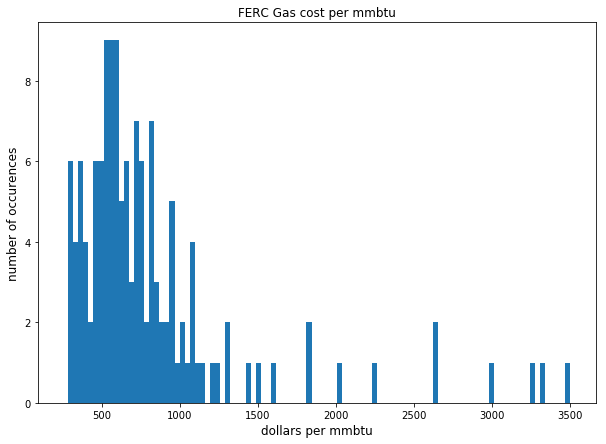

In [168]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu', 250,3500)

The third population is between .002 and .0175 - off by a factor of 1000. These values are likely the result of the utility entering the cost in mmbtu per cf rather than mmbtu per mcf.

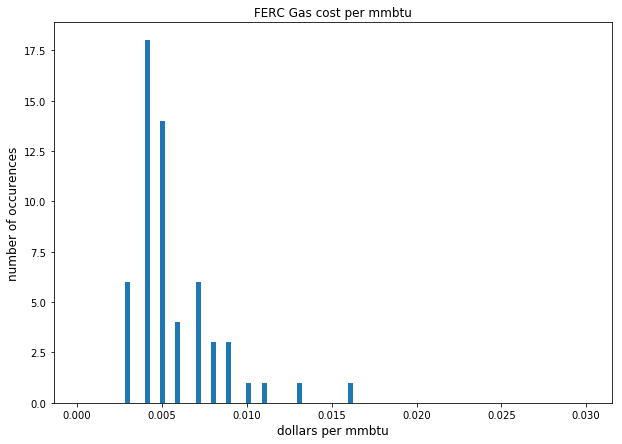

In [169]:
simplegraph(gas.fuel_cost_per_mmbtu,'dollars per mmbtu','number of occurences', 'FERC Gas cost per mmbtu',.0001,.03)

With the except of two records, all of these values are also attributable to utility `respondent_id` 130.

In [149]:
gas[(gas.fuel_cost_per_mmbtu > .0001) & (gas.fuel_cost_per_mmbtu < .02)]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
943,944,182,A. Mullergren,2007,gas,mcf,1572.0,1.046000,9.740,9.740,0.013,-25.0,0.000000
1051,1052,130,Horseshoe Lake,2007,gas,mcf,12516345.0,1.037000,6.874,0.000,0.007,78.0,11.690000
1053,1054,130,Seminole,2007,gas,mcf,38693460.0,1.037000,7.232,0.000,0.007,82.0,11.809000
1057,1058,130,Enid,2007,gas,mcf,38850.0,1.037000,6.386,0.000,0.006,151.0,23.672000
1059,1060,130,Muskogee,2007,gas,mcf,3682025.0,1.037000,6.247,0.000,0.006,69.0,11.173000
1060,1061,130,Mustang,2007,gas,mcf,9915051.0,1.037000,6.950,0.000,0.007,72.0,10.677000
1062,1063,130,Mcclain,2007,gas,mcf,18188683.0,1.037000,6.732,0.000,0.007,46.0,7.070000
1600,1601,130,Horseshoe Lake,2008,gas,mcf,9854405.0,1.037000,9.815,0.000,0.009,108.0,11.407000
1601,1602,130,Seminole,2008,gas,mcf,37163017.0,1.037000,8.840,0.000,0.008,98.0,11.594000
1604,1605,130,Enid,2008,gas,mcf,4003.0,1.037000,10.295,0.000,0.010,206.0,20.135000


Applying the two cleaning functions, we see a distribution peaking around 5 dollars per mmbtu with a tail out to 35 dollars per mmbtu.

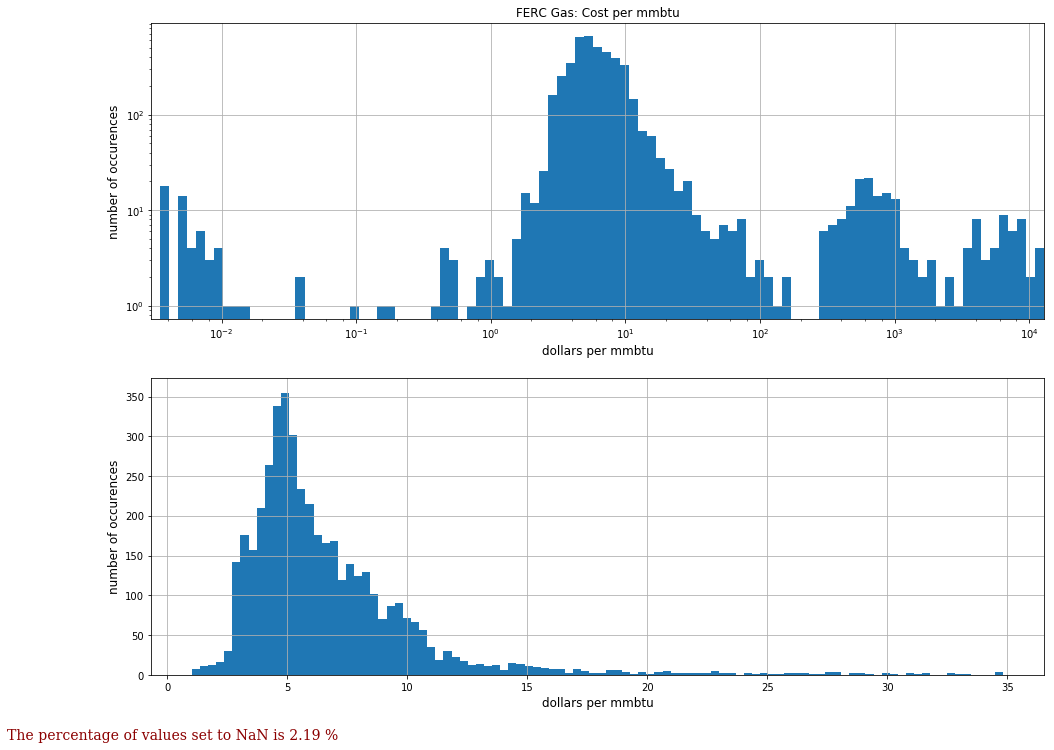

In [136]:
to_fix_cost_per_mmbtu_gas = gas.fuel_cost_per_mmbtu
fixed_cost_per_mmbtu_gas = fixit(gas.fuel_cost_per_mmbtu,1,35,[.01,1000])

showfix(to_fix_cost_per_mmbtu_gas,fixed_cost_per_mmbtu_gas,'FERC Gas: Cost per mmbtu',\
        'dollars per mmbtu','number of occurences')

### Oil cost per mmbtu
The price of a barrel of oil has fluctuated between 30 and 145 dollars per barrel over the last decade (https://www.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=RWTC&f=D). With roughly 5.8 mmbtu per barrel, we'd expect to find the primary distribution of oil cost per mmbtu around 5 to 25 dollars per mmbtu.

Let's first drop values at or below zero.

In [10]:
oil_cost_per_mmbtu = oil[oil.fuel_cost_per_mmbtu > 0]

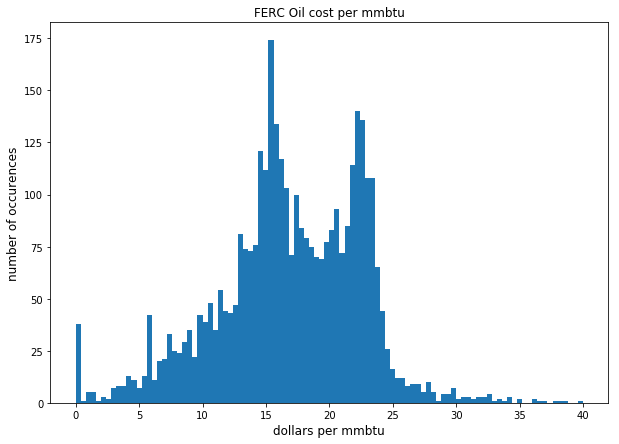

In [70]:
simplegraph(oil_cost_per_mmbtu.fuel_cost_per_mmbtu,'dollars per mmbtu',\
            'number of occurences', 'FERC Oil cost per mmbtu', 0,40)

Looking at the EIA cost per mmbtu data, one seems a distribution roughly between 5 and 40. When looking at the same values weighted by quantity delivered, the range is narrower, from 5 to roughly 33.

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


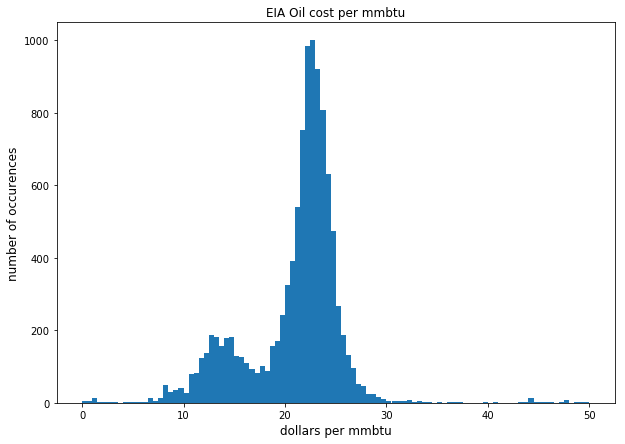

In [91]:
simplegraph(eia_rc_oil.fuel_cost,'dollars per mmbtu',\
            'number of occurences', 'EIA Oil cost per mmbtu', 0,50)

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


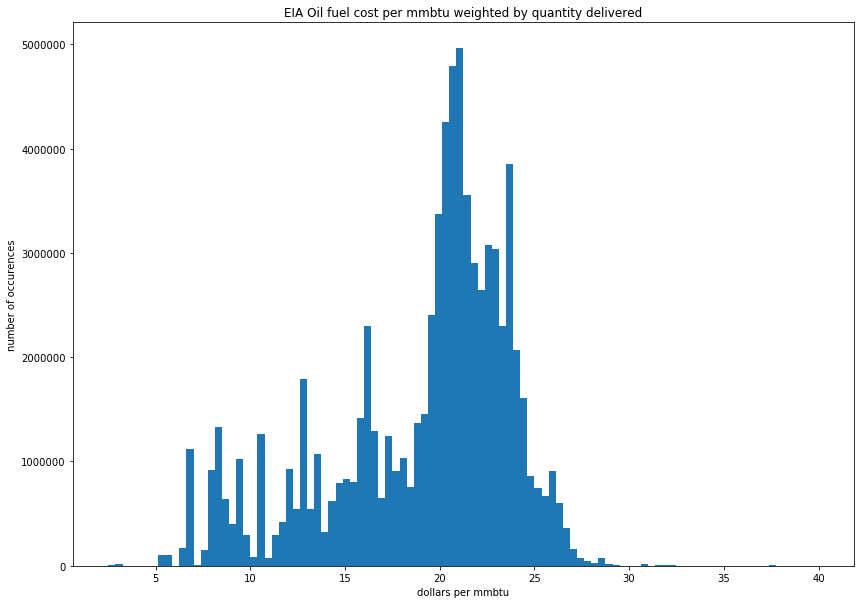

In [96]:
plt.figure(figsize=(14,10))
plt.hist(eia_rc_oil.fuel_cost,range=(2.5,40),weights=eia_rc_oil.fuel_quantity,bins=100)
plt.title('EIA Oil fuel cost per mmbtu weighted by quantity delivered')
plt.xlabel('dollars per mmbtu')
plt.ylabel('number of occurences')

Therefore, we'll use 5 and 33 as the boundaries for the primary distribution when cleaning the FERC oil cost per mmbtu data.

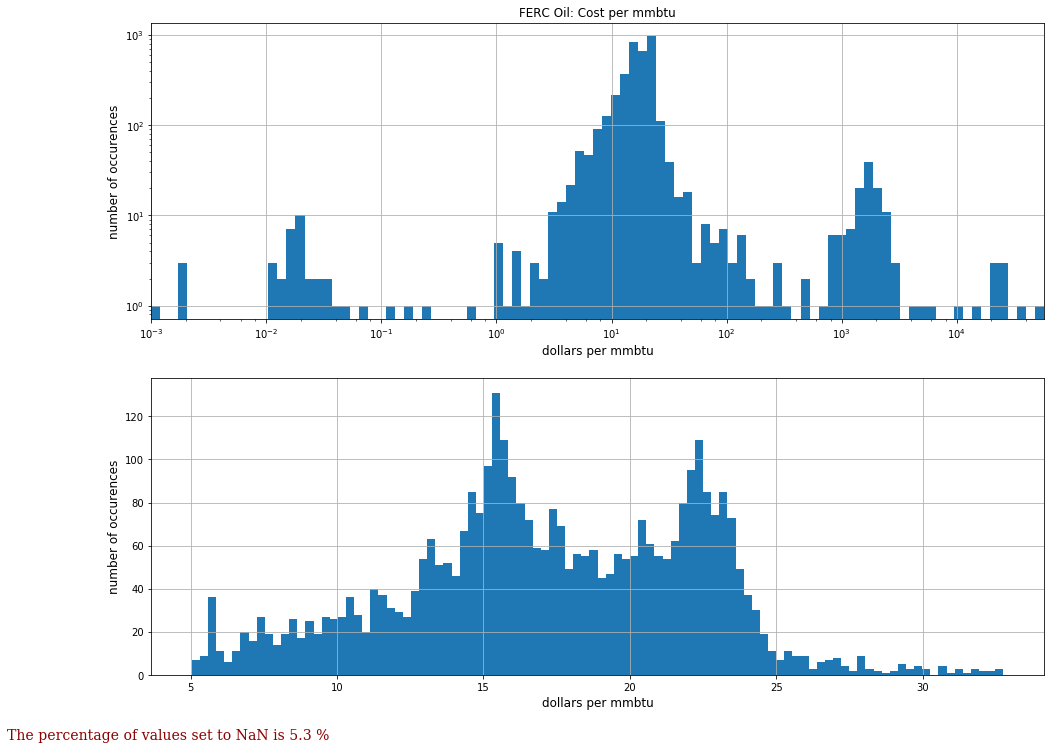

In [99]:
to_fix_cost_per_mmbtu_oil = oil.fuel_cost_per_mmbtu
fixed_cost_per_mmbtu_oil = fixit(oil.fuel_cost_per_mmbtu,5,33,[.01])

showfix(to_fix_cost_per_mmbtu_oil,fixed_cost_per_mmbtu_oil,'FERC Oil: Cost per mmbtu',\
        'dollars per mmbtu','number of occurences')

Once again, it looks like there is an outlying population where utilities entered data in cents per mmbtu rather than dollars per mmbtu, so we'll use a multiplier of .01 to correct this data and bring it into the primary distribution.

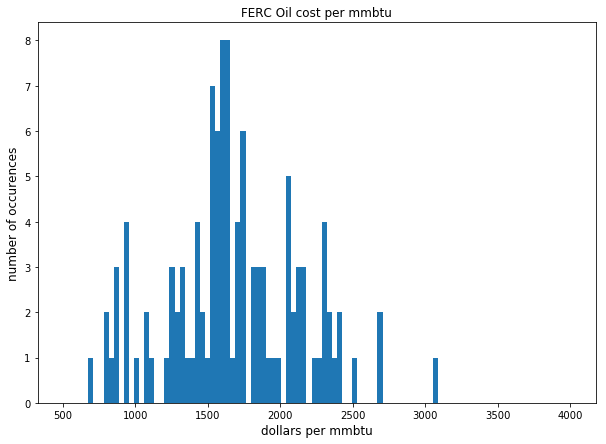

In [72]:
simplegraph(oil.fuel_cost_per_mmbtu,'dollars per mmbtu',\
            'number of occurences', 'FERC Oil cost per mmbtu', 500,4000)

There's a small population of values near .02 where three utilities - including utility 130! - have reported their oil cost per mmbtu but the cost values are 1000 times too small.

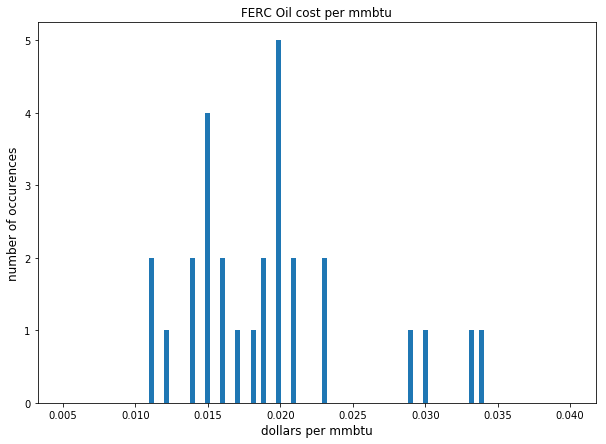

In [79]:
simplegraph(oil.fuel_cost_per_mmbtu,'dollars per mmbtu',\
            'number of occurences', 'FERC Oil cost per mmbtu', .005,.04)

In [77]:
oil[(oil.fuel_cost_per_mmbtu > .01) & (oil.fuel_cost_per_mmbtu < .1)]

,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
1056,1057,130,Sooner,2007,oil,bbl,24172.0,5.368698,66.087,0.000,0.011,123.0,10.800000
1061,1062,130,Mustang,2007,oil,bbl,59.0,5.324914,264.492,0.000,0.051,306.0,6.039000
1135,1136,227,Tower Diesel,2007,oil,1kgal,47137.0,0.137200,2.126,2.312,0.015,287366.0,0.018547
1603,1604,130,Sooner,2008,oil,bbl,12813.0,5.368698,89.706,0.000,0.015,149.0,9.668000
1608,1609,130,Mustang,2008,oil,bbl,59.0,5.324914,373.723,0.000,0.072,711.0,9.935000
2562,2563,227,Tower Diesel,2008,oil,1kgal,24260.0,0.137200,2.114,2.114,0.015,287489.0,0.018657
2870,2871,130,Sooner,2009,oil,bbl,14593.0,5.369698,91.340,0.000,0.016,177.0,11.286000
2875,2876,130,Mustang,2009,oil,bbl,18.0,5.324914,213.000,0.000,0.042,320.0,7.667000
3587,3588,227,Tower Diesel,2009,oil,1kgal,40618.0,0.137200,1.696,2.114,0.012,195527.0,0.015818
5033,5034,130,Sooner,2010,oil,bbl,12010.0,5.368698,91.115,0.000,0.016,176.0,11.248000
